### 제대로 된 스팸 필터기를 만들어보자
- Viagra 단어 외에 영향을 주는 단어들은?
- 오히려 스팸을 제외해주는 단어는 어떻게 찾지?
- <b>한번에 여러 단어들을 고려</b>하는 필터기를 만들자

### Feature의 확장
- y = 0 or 1
- P(spam|viagra) : P(y|x) → P(spam|viagra, hello, lucky, marketing...)
- 변수가 많을 때, 조건부 확률의 변화

### Multivariate multiplication rule
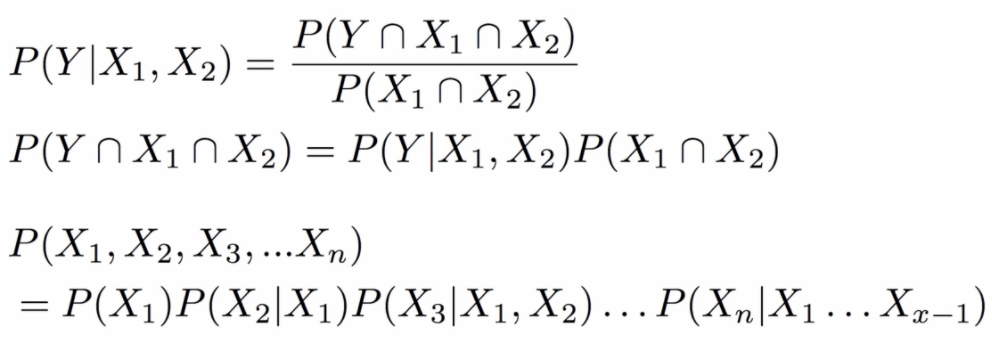

### Problems
- 계산이 너무 어려워짐
- Feature의 차원이 증가하면 Sparse Vector가 생성 → 확률이 0이 되는 값이 늘어남

### Naive Bayes Classifier
- <b>복잡하게 하지말고 단순(naive)하게 해결하자</b>
- 각 변수의 관계가 독립임을 가정 (=> P(A ∩ B) = P(A) * P(B) )
- 계산이 용이해지고, 성능이 생각보다 좋음

### Joint Probability
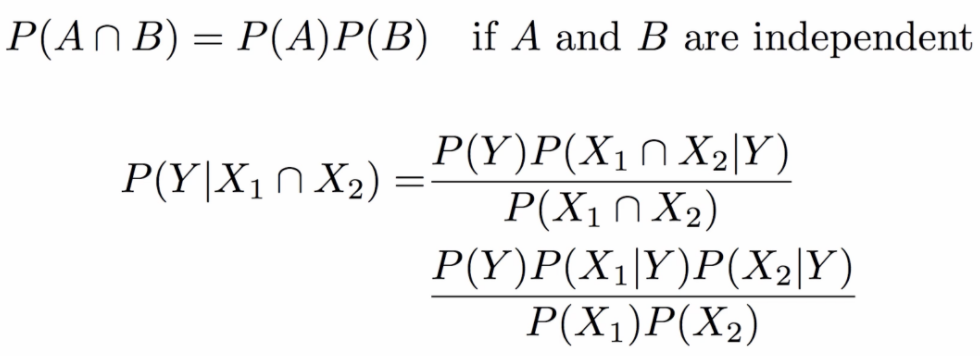

---
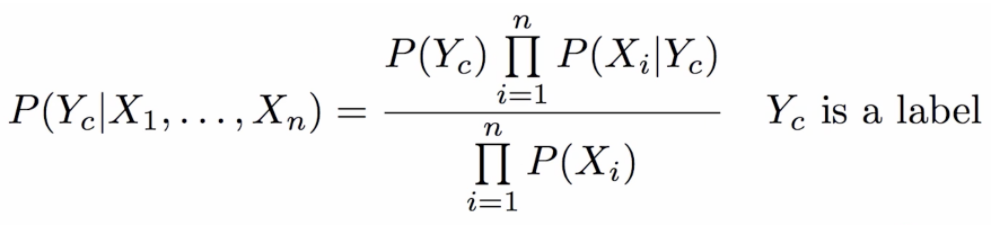

### Issues
- 너무 많은 확률값을 곱하면 → 0에 수렴하게 되는 문제
- 곱하지 말고 더하자 → log
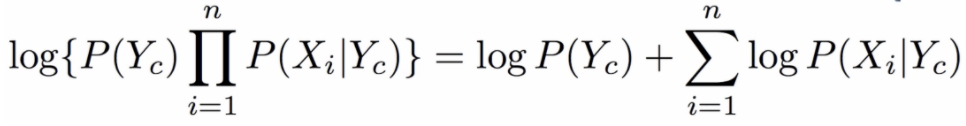
---
- 추가적인 issue로는, 확률이 0인 변수들이 존재함 → 전체값 0(= log(0)가 나올 경우 처리 필요)
- 작게나마 확률이 나올 수 있도록 변경 → "스무딩"
- 임의의 k를 설정(Generalize 효과)
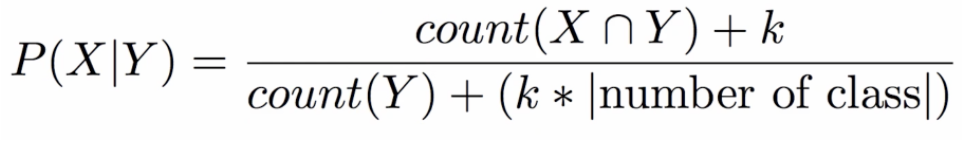

In [1]:
import pandas as pd
import numpy as np

### Dataset - German Credit
- "대출 사기인가?"를 예측하는 문제
- 데이터를 NB에 맞도록 간단하게 변환
- Binary 데이터들로 이루어진 대출 사기 데이터

In [5]:
data_url = 'data/fraud.csv'
df = pd.read_csv(data_url, sep = ',')
df.head()

,ID,History,CoApplicant,Accommodation,Fraud
0,1,current,none,own,True
1,2,paid,none,own,False
2,3,paid,none,own,False
3,4,paid,guarantor,rent,True
4,5,arrears,none,own,False


### Preprocessing

In [6]:
del df['ID']
Y_data = df.pop('Fraud')
Y_data = Y_data.values
Y_data

array([ True, False, False,  True, False,  True, False, False, False,
        True, False,  True,  True, False, False, False, False, False,
       False, False])

In [7]:
df.head()

,History,CoApplicant,Accommodation
0,current,none,own
1,paid,none,own
2,paid,none,own
3,paid,guarantor,rent
4,arrears,none,own


In [8]:
# One-Hot Encoding

x_df = pd.get_dummies(df)
x_df.head()

,History_arrears,History_current,History_none,History_paid,CoApplicant_coapplicant,CoApplicant_guarantor,CoApplicant_none,Accommodation_free,Accommodation_own,Accommodation_rent
0,0,1,0,0,0,0,1,0,1,0
1,0,0,0,1,0,0,1,0,1,0
2,0,0,0,1,0,0,1,0,1,0
3,0,0,0,1,0,1,0,0,0,1
4,1,0,0,0,0,0,1,0,1,0


In [9]:
x_data = x_df.values
x_data

array([[0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 1, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 1, 0],
       [1, 0, 0, 0, 1, 0, 0, 0, 0, 1],
       [1, 0, 0, 0, 0, 0, 1, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 1, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 1, 0]], dtype=uint8)

### Modeling
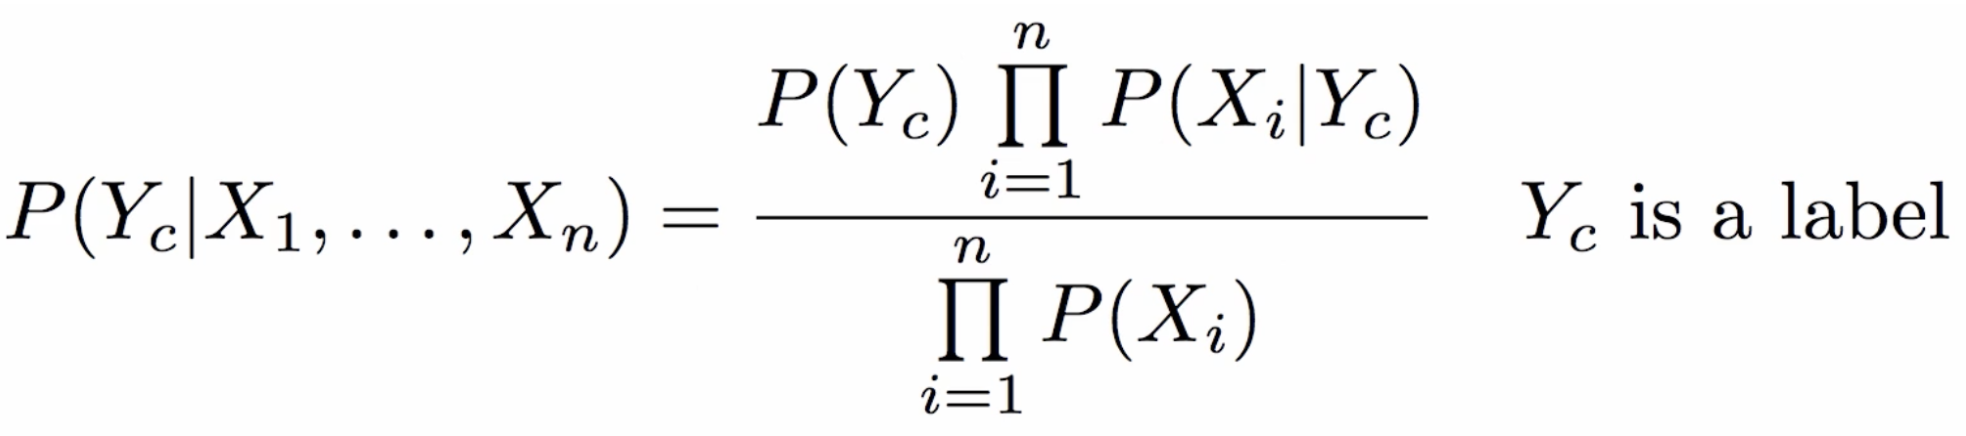
- 분모는 의미가 없어지게 됨(=> P(X<sub>i</sub>; feature)가 모든 경우에 거의 동일하기 때문, y가 1일 때 혹은 0일 때 영향을 주지 않음)

#### P(Y<sub>c</sub>) 구하기

In [11]:
P_Y_True = sum(Y_data == True) / len(Y_data)
P_Y_False = 1 - P_Y_True

P_Y_True, P_Y_False

(0.3, 0.7)

In [12]:
ix_Y_True = np.where(Y_data)             # Y=1일 때 index
ix_Y_False = np.where(Y_data == False)   # Y=0일 때 index

ix_Y_True, ix_Y_False

((array([ 0,  3,  5,  9, 11, 12]),),
 (array([ 1,  2,  4,  6,  7,  8, 10, 13, 14, 15, 16, 17, 18, 19]),))

##### 가장 중요한 P(X<sub>i</sub> | Y<sub>c</sub>)를 구하기

In [13]:
p_x_y_true = (x_data[ix_Y_True].sum(axis = 0)) / sum(Y_data == True)       # count(Y=1)일 때 X1 ~ X10의 확률
p_x_y_false = (x_data[ix_Y_False].sum(axis = 0)) / sum(Y_data == False)    # count(Y=0)일 때 X1 ~ X10의 확률

p_x_y_true, p_x_y_false 

(array([0.16666667, 0.5       , 0.16666667, 0.16666667, 0.        ,
        0.16666667, 0.83333333, 0.        , 0.66666667, 0.33333333]),
 array([0.42857143, 0.28571429, 0.        , 0.28571429, 0.14285714,
        0.        , 0.85714286, 0.07142857, 0.78571429, 0.14285714]))

### Classifier
- P(Y=1 | X)의 확률과 P(Y=0 | X)의 확률 비교

In [16]:
x_test = [0, 1, 0, 0, 0, 1, 0, 0, 1, 0]

p_y_true_test = P_Y_True * p_x_y_true.dot(x_test)
p_y_false_test = P_Y_False * p_x_y_false.dot(x_test)

p_y_true_test, p_y_false_test

(0.39999999999999997, 0.7499999999999999)

#### 결론 : 이 x_test는 "대출 사기가 아니다"(False의 확률이 더 높음)

In [17]:
p_y_true_test < p_y_false_test

True